# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1  Device: cpu


## 3. CIFAR10 Data Normalization and Augmentation

In [3]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


문제) 학습 데이터(training data)의 색상별 평균과 표준 편차를 구하자.

In [4]:
print(train_data.data.shape)
print(train_data.data.mean(axis=(0,1,2))/255)
print(train_data.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


문제) 위 내용을 반영하여 데이터를 Normalize 하고 랜덤하게 좌우반전 및 흑백 사진으로 바꾸자.

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomGrayscale(0.5),
        transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091],
                             std=[0.24703223, 0.24348513, 0.26158784])
    ])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


완성된 dataset.CIFAR10 객체를 train_loader에 넣는다.

In [6]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)    

아래의 코드를 여러번 돌려, 실제로 좌우반전 및 흑백사진으로 변하는지 확인하자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


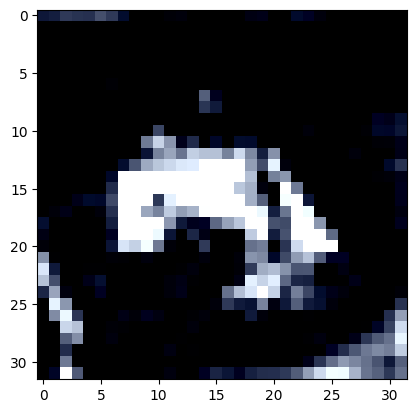

In [7]:
for (X_train, y_train) in train_loader:
    plt.imshow(X_train[0].permute(1,2,0).numpy())
    plt.show()
    break

## 4. torch.nn을 이용하여 모델-1 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Batch Normalization 을 사용할 것

In [8]:
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1,self).__init__()
        self.fc1 = nn.Linear(3*32*32, 100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(100)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 5. torch.nn을 이용하여 모델-2 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Dropout을 확률을 50%로 사용할 것 - BN는 사용하지 말것!

In [9]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2,self).__init__()
        self.fc1 = nn.Linear(3*32*32, 100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [10]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(batch_size, -1)

        # Forward propagration 계산하기.
        outputs = network(image)
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs,label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = outputs.data.max(1)[1]
        train_correct += pred.eq(label).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [11]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(batch_size,-1)

            # Forward propagration 계산하기.
            outputs = network(image)

            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs,label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = outputs.data.max(1)[1]
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

1. SGD Optimizer를 사용하고

2. Regularizer 를 사용하여 (weight_decay = 0.01로 사용할 것)

학습시키기

In [12]:
def training(network, learning_rate = 0.01):
    
#   learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.01)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [13]:
network = Model_1()
rlt_const = training(network)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.429538
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.972217
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.015101
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.947342

Training set: Accuracy: 17073/50000 (34%)
Test set: Accuracy: 3918/10000 (39%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.898147
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.865107
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.950563
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.934846

Training set: Accuracy: 19249/50000 (38%)
Test set: Accuracy: 4092/10000 (41%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.870820
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.750338
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.867347
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.967707

Training set: Accuracy: 20023/50000 (40%)
Test set: Accuracy: 4217/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.834279
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.821329
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.760748
Train Epoch: 3 [48000/50000

In [14]:
network2 = Model_2()
rlt_const2 = training(network2, 0.002)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.398739
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.272753
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.059919
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.978346

Training set: Accuracy: 13265/50000 (27%)
Test set: Accuracy: 3357/10000 (34%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.944891
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.191121
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.107135
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.086470

Training set: Accuracy: 15696/50000 (31%)
Test set: Accuracy: 3610/10000 (36%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.849585
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.946961
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.950979
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.889352

Training set: Accuracy: 16520/50000 (33%)
Test set: Accuracy: 3715/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.821410
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.950027
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.856252
Train Epoch: 3 [48000/50000

# 8.학습 결과 보기 
## loss와 Accuracy 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

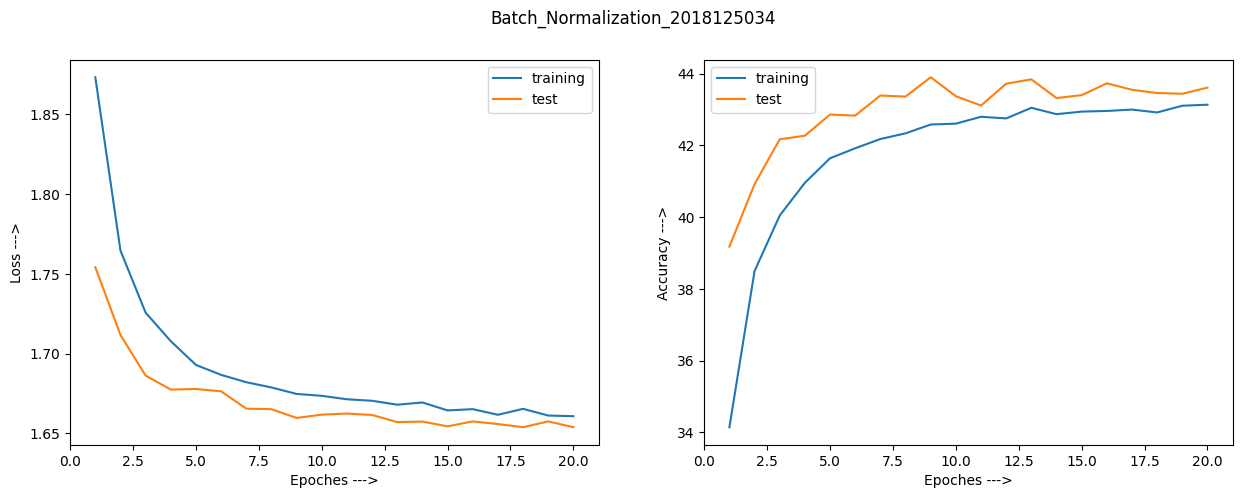

In [16]:
show_rlt(rlt_const, 'Batch_Normalization_2018125034')

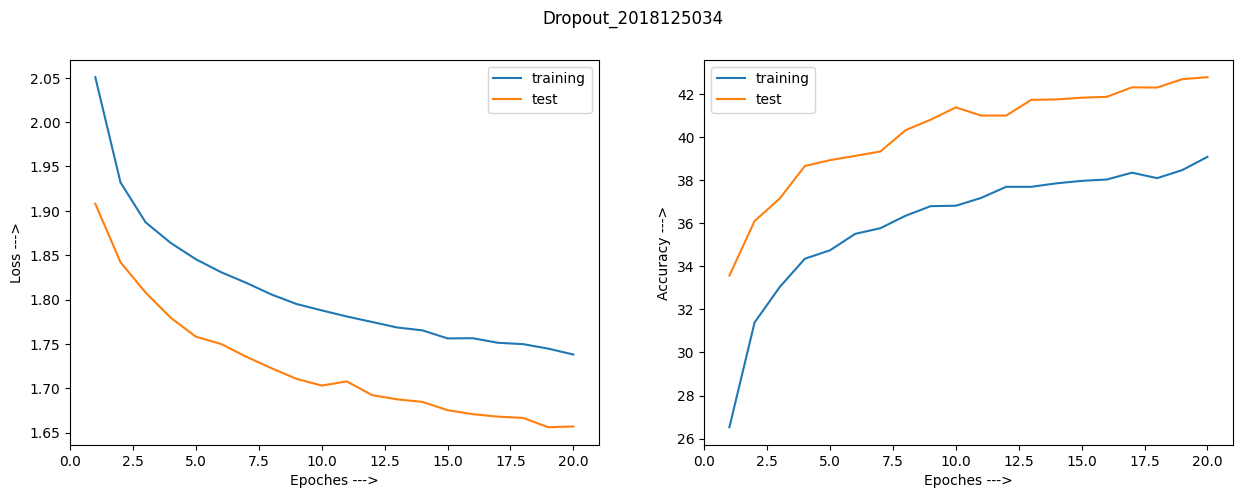

In [17]:
show_rlt(rlt_const2, 'Dropout_2018125034')

# 9. Hyperparameter 찾기

위 Dropout 모델의 최적의 learning rate를 찾으세요.

스스로 계획을 짜고 어떤 lr 이 가장 나은 성능을 내었는지 분석하세요.

Random search 기법을 이용
0. lr의 범위는 0.00001 ~ 0.01로 설정
1. 범위 안에서 무작위로 추출 => 0.00005, 0.0001, 0.0003, 0.001, 0.006, 0.01 ...
2. 각각의 lr로 학습을 진행
3. 1&2단계를 반복한 결과, 발견한 최적의 lr은 0.003이다.

lr이 0.00005인 경우,loss도 감소하고 accuracy도 서서히 증가하였다.
lr이 0.0001인 경우, loss도 감소하고 accuracy도 서서히 증가하였다. 하지만 20epoch만으론 batch_normalization을 적용한 모델에 비해 성능이 부족하였다.<br>
lr이 0.0003인 경우, lr이 0.0001일 때보다 loss가 더 감소하고, accuracy도 더 증가했지만 bn을 적용한 모델에는 역시 미치지 못하였다.<br>
lr이 0.001인 경우, lr이 0.0003일 때보다 loss가 더 감소하고, accuracy도 더 증가하였다.<br>
lr이 0.006인 경우, lr이 0.001일 때보다 test loss, train loss 그리고 test accuracy와 train accuracy간 간격이 더 벌어졌다. overfitting 문제가 발생할 수 있다.<br>
lr이 0.01인 경우, test loss가 감소하고 test accuracy는 증가했지만, train loss와 train accuracy간 간격이 더 넓어졌다. <br>

위 결과를 종합해본 바, 현재 과제에서 Dropout을 적용한 모델의 최적의 lr은 0.003이라고 생각한다. 0.003보다 커질 경우 test 정확도와 train 정확도의 차이가 점점 커졌으며, 0.003보다 작을 경우 test 정확도와 train 정확도간 차이가 0.003일 때와 비교했을 때 유의미하지 않고 성능은 0.003에 비해 낮음을 확인하였기 때문에 최적의 lr을 0.003이라고 생각한다.